## Para datos ómicos (por ejemplo, conteos de genes, OTUs, metabolitos, etc.) solemos aplicar varios pasos de procesamiento para que el análisis refleje de manera más fiel las diferencias reales entre muestras. 

## Tres conceptos que a menudo se confunden son escalado, normalización y ordenación, pero cada uno tiene un objetivo y un efecto diferente:

## 1. Escalado (Scaling)

**¿Qué es?**

Ajustar la escala de los valores de cada variable (por ejemplo, cada gen o cada OTU) de forma que sean comparables entre sí.

**Ejemplos de escalado**

Estandarización z-score: restar la media y dividir entre la desviación estándar de cada variable para que tenga media 0 y desviación estándar 1.

Min-Max Scaling: reescalar valores a un rango fijo, por ejemplo, de 0 a 1.

Log-transformación: en datos con amplia dispersión (cuentas muy bajas y muy altas), a menudo se aplica log(𝑥+1).

**¿Para qué sirve?**

Evitar que variables con valores numéricamente grandes (p.ej., genes altamente expresados) dominen el análisis.

Hacer que todos los atributos tengan el mismo “peso” en métodos que son sensibles a la magnitud de los datos (por ejemplo, distancias Euclidianas en un PCA).

## 2. Normalización (Normalization)

**¿Qué es?**

Procedimientos para ajustar las diferencias sistemáticas entre muestras, de modo que los valores de abundancia/expresión puedan ser comparados de forma justa.

**Ejemplos de normalización en ómics**

* En RNA-Seq: métodos como TPM (Transcripts Per Million), RPKM/FPKM, o DESeq normalization, que corrigen por la longitud de los genes y/o el tamaño de la librería (depth de secuenciación).

* En metagenómica: normalizar por profundidad de secuenciación total o por factores de corrección como TMM (Trimmed Mean of M-values).

**¿Para qué sirve?**

Quitar el efecto de que unas muestras tengan más lecturas (reads) totales que otras.
Evitar sesgos cuando se comparan abundancias relativas entre distintos genes u OTUs.

## 3. Ordenación (Ordination)

**¿Qué es?**

Técnicas estadísticas o de machine learning para reducir la dimensionalidad de los datos y visualizar las relaciones entre muestras (o entre variables) en un espacio de pocas dimensiones (2D o 3D).

**Ejemplos de métodos de ordenación**

* PCA (Análisis de Componentes Principales): busca ejes que expliquen la mayor varianza posible.

* PCoA (Análisis de Coordenadas Principales): usa una matriz de distancias (p.ej. Bray-Curtis) para ubicar muestras en un espacio de menor dimensión.

* NMDS (Escalado Multidimensional no métrico): también parte de una matriz de similitudes/distancias y busca una representación en 2D o 3D.

* t-SNE, UMAP: métodos más avanzados para datos de muy alta dimensión (por ejemplo, single-cell omics).

**¿Para qué sirve?**

Visualizar patrones globales, agrupamientos o gradientes de variación en las muestras.
Explorar qué factores (condiciones experimentales, variables ambientales, etc.) explican la mayor parte de la variación.

## Resumen

**Escalado:** cambia la escala de las variables para que tengan un rango o una varianza similar (evitar que una variable con valores grandes “domine” la estadística).

**Normalización:** ajusta sesgos globales entre muestras (por ejemplo, distinto número de lecturas totales, longitud de genes, etc.) para poder comparar abundancias o expresiones de manera consistente.

**Ordenación:** métodos para reducir dimensionalidad y visualizar/interpretar relaciones entre muestras o variables en un espacio de menor dimensión.

En muchos flujos de análisis, primero se normalizan los datos para hacer comparables las muestras, luego se aplica algún tipo de escalado (si se requiere para el método estadístico), y finalmente se lleva a cabo la ordenación para explorar las relaciones y patrones de variación.

## A nineteen gene-based risk score classifier predicts prognosis of colorectal cancer patients

Colorectal cancer (CRC) patients frequently experience disease recurrence and distant metastasis. This study aimed to identify prognostic indicators, including individual re- sponses to chemotherapy, in CRC patients. RNA-seq data was generated using 54 samples (normal colon, primary CRC, and liver metastases) from 18 CRC patients and genes associ- ated with CRC aggressiveness were identified. A risk score based on these genes was devel- oped and validated in four independent CRC patient cohorts (n 1⁄4 1063). Diverse statistical methods were applied to validate the risk scoring system, including a generalized linear model likelihood ratio test, KaplaneMeier curves, a log-rank test, and the Cox model. TREM1 and CTGF were identified as two activated regulators associated with CRC aggres- siveness. A risk score based on 19 genes regulated by TREM1 or CTGF activation (TCA19) was a significant prognostic indicator. In multivariate and subset analyses based on path- ological staging, TCA19 was an independent risk factor (HR 1⁄4 1.894, 95% CI 1⁄4 1.227e2.809, P 1⁄4 0.002). Subset stratification in stage III patients revealed that TCA19 had prognostic po- tential and identified patients who would benefit from adjuvant chemotherapy, regardless of age. The TCA19 predictor represents a novel diagnostic tool for identifying high-risk CRC patients and possibly predicting the response to adjuvant chemotherapy.


**origen de los datos:** https://www.ebi.ac.uk/gxa/experiments/E-GEOD-50760/Experiment%20Design


In [20]:
######################################################################################################################################
# Biología de sistemas "EAFIT" 2024
# Análisis de expresión diferencial de genes
#
# Este script procesa datos de expresión génica, identifica genes diferencialmente expresados y 
# realiza análisis exploratorios (escalado, normalización y ordenación: PCA y PCoA).
#
# NOTA: DESeq2 normaliza automáticamente mediante size factors y se utiliza la transformación VST para 
# estabilizar la varianza (escalado) previo a la exploración mediante PCA y PCoA.
######################################################################################################################################

#########################################
# 1. Instalación y carga de librerías
#########################################
# (Descomente las líneas de instalación si es la primera vez que usa estos paquetes)
# if (!require('BiocManager', quietly = TRUE))
#   install.packages('BiocManager')
# BiocManager::install('DESeq2')
# BiocManager::install('EnhancedVolcano')
# install.packages('pheatmap')
# install.packages('ggplot2')

library(DESeq2)
library(EnhancedVolcano)
library(pheatmap)
library(ggplot2)

In [ ]:
#########################################
# 2. Carga de datos: Diseño experimental y recuentos sin procesar
#########################################
# Cargar archivo con el diseño experimental. Se asume que las primeras 18 muestras son tumores primarios (cáncer)
# y las siguientes 19 muestras son normales. Para este análisis se utilizan solo las primeras 37.

design <- read.delim('/Users/usuario/Documents/programas/oncology_diff_express/E-GEOD-50760-experiment-design.tsv')
View(design)

# Cargar el conjunto de datos de recuentos sin procesar
raw.counts <- read.delim('/Users/usuario/Documents/programas/oncology_diff_express/E-GEOD-50760-raw-counts.tsv')
View(raw.counts)

Run,Sample.Characteristic.biopsy.site.,Sample.Characteristic.Ontology.Term.biopsy.site.,Sample.Characteristic.disease.,Sample.Characteristic.Ontology.Term.disease.,Sample.Characteristic.disease.staging.,Sample.Characteristic.Ontology.Term.disease.staging.,Sample.Characteristic.individual.,Sample.Characteristic.Ontology.Term.individual.,Sample.Characteristic.organism.,Sample.Characteristic.Ontology.Term.organism.,Sample.Characteristic.organism.part.,Sample.Characteristic.Ontology.Term.organism.part.,Factor.Value.biopsy.site.,Factor.Value.Ontology.Term.biopsy.site.,Analysed
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR975551,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_2,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975552,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_3,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975553,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_5,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975554,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_6,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975555,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_7,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975556,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_8,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975557,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_9,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975558,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_10,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes
SRR975559,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,colorectal cancer,http://www.ebi.ac.uk/efo/EFO_0005842,Stage IV Colorectal Cancer,NA,AMC_12,NA,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,colon,http://purl.obolibrary.org/obo/UBERON_0001155,primary tumor,http://www.ebi.ac.uk/efo/EFO_0000616,Yes


Gene.ID,Gene.Name,SRR975562,SRR975555,SRR975597,SRR975571,SRR975553,SRR975567,SRR975590,SRR975581,...,SRR975604,SRR975594,SRR975560,SRR975580,SRR975570,SRR975602,SRR975561,SRR975573,SRR975587,SRR975576
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,1990,874,1011,1366,867,619,1800,385,...,1144,566,1065,1596,394,1451,804,571,1825,783
ENSG00000000005,TNMD,12,4,6,11,12,1,3,2,...,3,0,3,17,1,0,4,13,2,2
ENSG00000000419,DPM1,681,978,610,432,293,400,560,157,...,689,134,384,444,157,560,301,229,717,192
ENSG00000000457,SCYL3,165,221,138,309,207,248,158,146,...,185,89,133,178,133,85,147,182,165,146
ENSG00000000460,C1orf112,88,109,88,42,38,108,116,27,...,50,25,37,66,20,84,21,37,138,19
ENSG00000000938,FGR,60,84,81,121,89,93,66,47,...,378,74,66,59,23,38,54,44,124,46
ENSG00000000971,CFH,375,201,1350,1615,1035,589,1685,935,...,6253,19581,518,268,354,65,449,640,7902,471
ENSG00000001036,FUCA2,955,991,276,914,623,504,633,451,...,836,344,709,1063,353,509,317,438,887,484
ENSG00000001084,GCLC,435,693,551,650,421,645,837,339,...,812,785,366,406,255,424,308,430,992,280


In [22]:
#########################################
# 3. Preparación de datos: Selección de muestras, etiquetas y metadata
#########################################
# Seleccionar únicamente las primeras 37 muestras (tumores primarios y normales)
design <- design[1:37,]

# Crear etiquetas para las muestras: 18 de "cancer" y 19 de "normal"
label1 <- rep("cancer", 18)
label2 <- rep("normal", 19)
labels <- c(label1, label2)

# Extraer la columna de nombres de genes y los recuentos correspondientes a las muestras de interés
dataset <- raw.counts[, c("Gene.Name", design$Run)]
genetable <- raw.counts[, design$Run]

# Crear el dataframe de metadatos para DESeq2
Metadata <- data.frame(id = design$Run, type = labels)

## Normalización

In [12]:
#########################################
# 4. Creación del objeto DESeq2 y ejecución del análisis diferencial
#########################################
# Crear el objeto DESeqDataSet; DESeq2 calculará los size factors (normalización) y estimará la dispersión
dds <- DESeqDataSetFromMatrix(genetable, Metadata, ~ type)
dds <- DESeq(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1354 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



## Escalado (VST) y Ordenación (PCA-PCoA)

using ntop=500 top features by variance



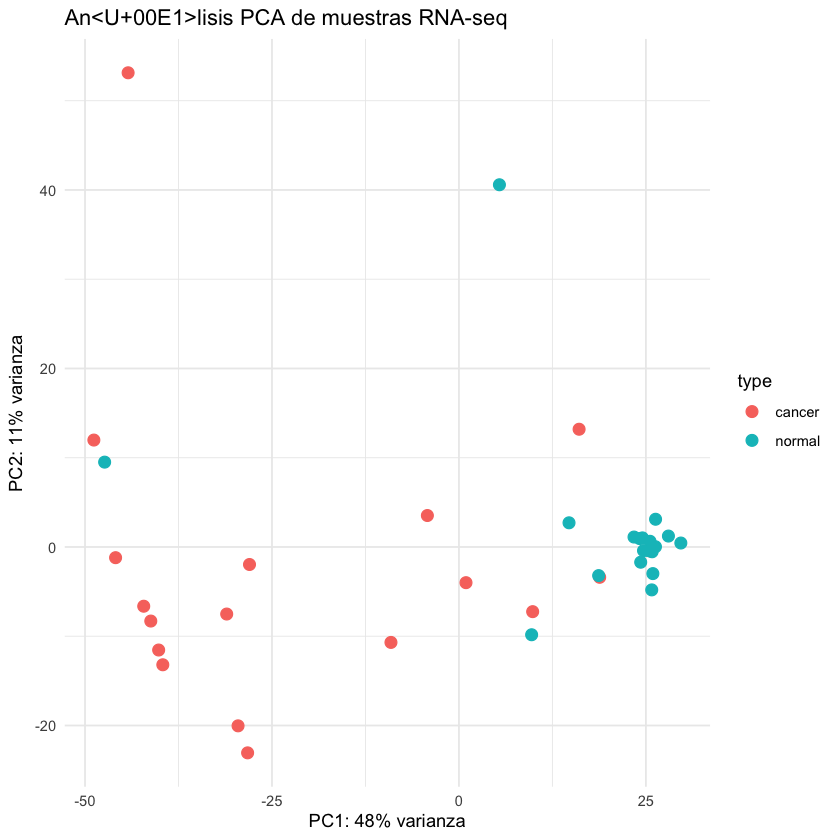

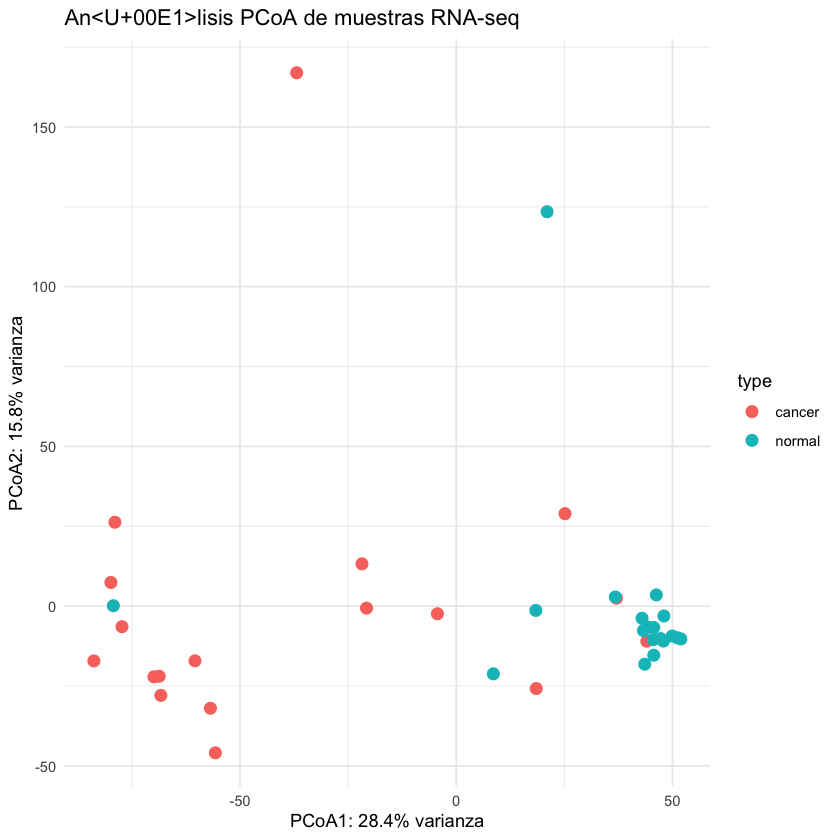

In [13]:
#########################################
# 5. Análisis Exploratorio: Escalado y Ordenación (PCA y PCoA)
#########################################
# Aplicar transformación de varianza estabilizada (VST)
# Esta transformación "escala" los datos para estabilizar la varianza a lo largo de la gama de expresión
vsd <- vst(dds, blind = FALSE)

## Análisis de PCA
# Extraer datos del PCA (incluye porcentaje de varianza explicada) y graficar usando ggplot2
pcaData <- plotPCA(vsd, intgroup = "type", returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

pca_plot <- ggplot(pcaData, aes(PC1, PC2, color = type)) +
  geom_point(size = 3) +
  xlab(paste0("PC1: ", percentVar[1], "% varianza")) +
  ylab(paste0("PC2: ", percentVar[2], "% varianza")) +
  ggtitle("Análisis PCA de muestras RNA-seq") +
  theme_minimal()
print(pca_plot)

## Análisis de PCoA
# Calcular la matriz de distancias (usando los datos transformados por VST)
vsd_mat <- assay(vsd)       # Extraer la matriz de expresión transformada
d <- dist(t(vsd_mat))       # Calcular distancias entre muestras (transponer: cada fila es una muestra)

# Realizar el análisis de coordenadas principales (PCoA) utilizando cmdscale
pcoa <- cmdscale(d, k = 2, eig = TRUE)

# Preparar el dataframe para graficar, incluyendo las coordenadas PCoA y la información de tipo de muestra
pcoa_data <- data.frame(
  PCoA1 = pcoa$points[, 1],
  PCoA2 = pcoa$points[, 2],
  type = colData(vsd)$type
)

# Calcular porcentaje de varianza explicado por cada eje de la PCoA
eig_sum <- sum(pcoa$eig)
var1 <- round(100 * pcoa$eig[1] / eig_sum, 1)
var2 <- round(100 * pcoa$eig[2] / eig_sum, 1)

pcoa_plot <- ggplot(pcoa_data, aes(PCoA1, PCoA2, color = type)) +
  geom_point(size = 3) +
  xlab(paste0("PCoA1: ", var1, "% varianza")) +
  ylab(paste0("PCoA2: ", var2, "% varianza")) +
  ggtitle("Análisis PCoA de muestras RNA-seq") +
  theme_minimal()
print(pcoa_plot)

In [14]:
#########################################
# 6. Obtención de resultados de expresión diferencial
#########################################
# Se extraen los resultados de DESeq2 comparando "cancer" vs "normal".
# Primero se usa la corrección de Benjamini-Hochberg (BH), luego se utiliza la corrección de Holm (más conservadora).

# Resultados con corrección BH
res <- results(object = dds, contrast = c("type", "cancer", "normal"),
               pAdjustMethod = "BH", alpha = 0.000001)
row.names(res) <- dataset$Gene.Name
summary(res)

# Resultados con corrección Holm (más conservadora)
res <- results(object = dds, contrast = c("type", "cancer", "normal"),
               pAdjustMethod = "holm", alpha = 0.000001)
row.names(res) <- dataset$Gene.Name
summary(res)


out of 40166 with nonzero total read count
adjusted p-value < 1e-06
LFC > 0 (up)       : 121, 0.3%
LFC < 0 (down)     : 30, 0.075%
outliers [1]       : 0, 0%
low counts [2]     : 17491, 44%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 40166 with nonzero total read count
adjusted p-value < 1e-06
LFC > 0 (up)       : 46, 0.11%
LFC < 0 (down)     : 11, 0.027%
outliers [1]       : 0, 0%
low counts [2]     : 18251, 45%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Warning message:
"ggrepel: 652 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


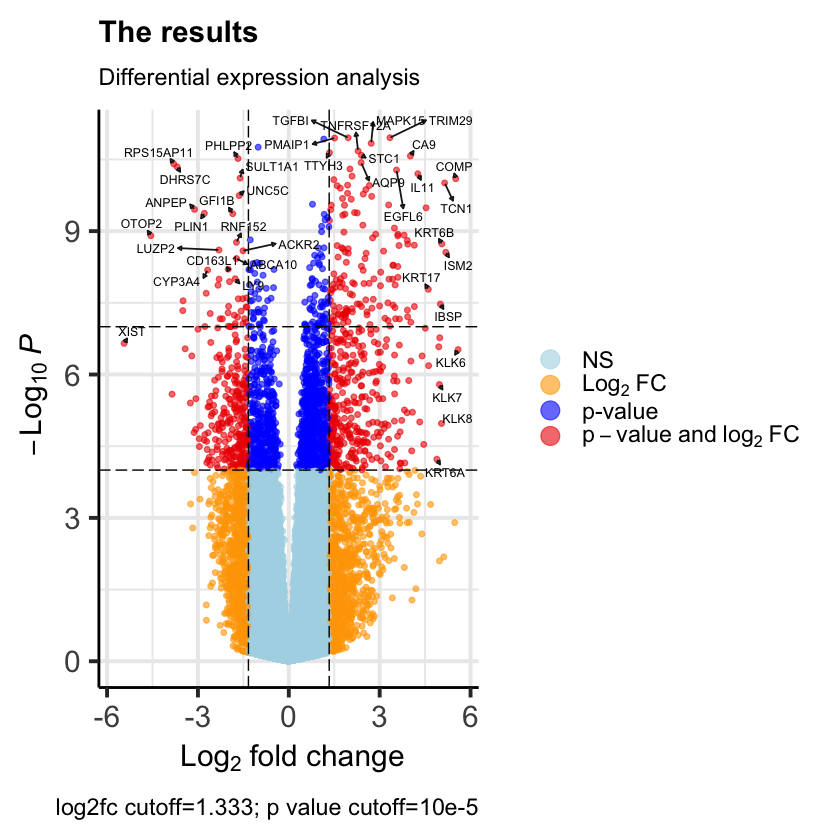

In [20]:
#########################################
# 7. Visualización de resultados: Gráficos de Volcán
#########################################
# Crear gráfico de volcán utilizando EnhancedVolcano. Se muestran dos versiones: 
# una usando el valor p original y otra usando el valor p ajustado (padj).

# Volcán usando pvalue
EnhancedVolcano(res,
                lab = dataset$Gene.Name,
                x = "log2FoldChange",
                y = "pvalue",
                pCutoff = 10e-5,
                FCcutoff = 1.333,
                xlim = c(-5.7, 5.7),
                ylim = c(0, -log10(10.2e-12)),
                pointSize = 1.3,
                labSize = 2.6,
                title = "The results",
                subtitle = "Differential expression analysis",
                caption = "log2fc cutoff=1.333; p value cutoff=10e-5",
                legendPosition = "right",
                legendLabSize = 14,
                col = c("lightblue", "orange", "blue", "red2"),
                colAlpha = 0.6,
                drawConnectors = TRUE,
                hline = c(10e-8),
                widthConnectors = 0.5)



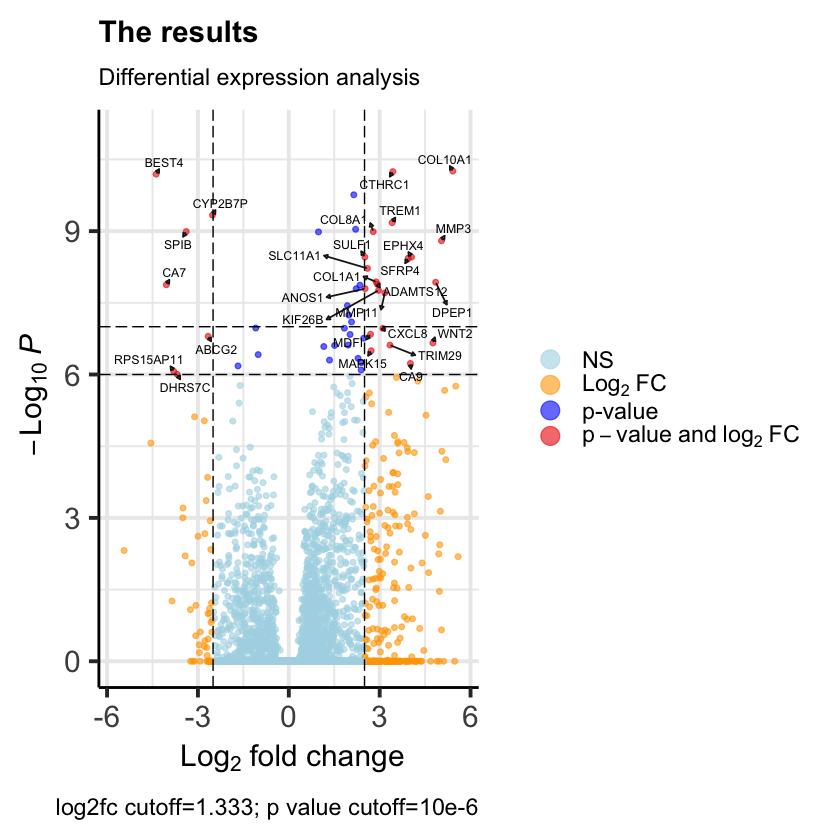

In [21]:
# Volcán usando padj
EnhancedVolcano(res,
                lab = dataset$Gene.Name,
                x = "log2FoldChange",
                y = "padj",
                pCutoff = 10e-7,
                FCcutoff = 2.5,
                xlim = c(-5.7, 5.7),
                ylim = c(0, -log10(10.2e-12)),
                pointSize = 1.3,
                labSize = 2.6,
                title = "The results",
                subtitle = "Differential expression analysis",
                caption = "log2fc cutoff=1.333; p value cutoff=10e-6",
                legendPosition = "right",
                legendLabSize = 14,
                col = c("lightblue", "orange", "blue", "red2"),
                colAlpha = 0.6,
                drawConnectors = TRUE,
                hline = c(10e-8),
                widthConnectors = 0.5)

In [18]:
#########################################
# 8. Generación de tabla final y filtrado de genes significativos
#########################################
# Crear un dataframe final ordenado por log2FoldChange
resord <- as.data.frame(res)
finaltable <- cbind(dataset$Gene.Name, resord)
finaltable <- finaltable[order(finaltable$log2FoldChange), ]
write.table(finaltable, file = "/Users/usuario/Documents/programas/oncology_diff_express/finaltable_ori.csv", sep = ",", col.names = NA)
print(finaltable)


                            dataset$Gene.Name     baseMean log2FoldChange
XIST                                     XIST 2.509690e+01     -5.4376146
OTOP3                                   OTOP3 1.351667e+01     -5.0460697
OTOP2                                   OTOP2 2.987881e+02     -4.5554321
BEST4                                   BEST4 6.554730e+02     -4.3803165
CA7                                       CA7 5.621403e+02     -4.0434602
CIDEA                                   CIDEA 1.682543e+00     -3.8547797
RPS15AP11                           RPS15AP11 2.881839e+00     -3.7980273
DHRS7C                                 DHRS7C 3.880859e+00     -3.6863165
MS4A10                                 MS4A10 5.304518e+00     -3.4993662
LINC02490                           LINC02490 5.320564e+00     -3.4909989
TRARG1                                 TRARG1 6.026618e+00     -3.4214231
SPIB                                     SPIB 3.150731e+02     -3.3865684
G6PC1                                 

In [19]:
# Filtrar genes significativos: padj < 10e-7 y log2FoldChange >= 2.5 o <= -2.5
significativos <- resord[which(resord$padj < 10e-7 & (resord$log2FoldChange >= 2.5 | resord$log2FoldChange <= -2.5)), ]
significativos_table <- significativos
significativos_table$Gene.Name <- rownames(significativos)
colnames(significativos_table)[ncol(significativos_table)] <- "Gene.Name"
write.table(significativos_table, file = "/Users/usuario/Documents/programas/oncology_diff_express/significativo.csv", sep = ",", row.names = FALSE, col.names = TRUE)
print(significativos_table)

              baseMean log2FoldChange     lfcSE      stat       pvalue
ANOS1        46.502621       2.519705 0.3512407  7.173727 7.298291e-13
DPEP1      1050.123859       4.848482 0.6719250  7.215809 5.361413e-13
SLC11A1      41.623360       2.597323 0.3554971  7.306172 2.748605e-13
COL11A1     201.769414       5.047925 0.5335175  9.461593 3.032863e-21
FAP          79.635628       3.747493 0.4605291  8.137366 4.039708e-16
MMP11       464.716336       3.171252 0.4437747  7.146086 8.928698e-13
CEMIP       345.042319       3.790209 0.4085920  9.276268 1.755192e-20
WNT2         37.761825       4.757172 0.6989300  6.806364 1.000960e-11
SFRP4       183.389849       3.944232 0.5350320  7.371955 1.681436e-13
CA9          53.357938       4.013260 0.6023016  6.663207 2.679161e-11
COL1A1    13434.385970       2.880667 0.3990659  7.218525 5.255442e-13
MDFI         58.193935       2.698198 0.3929335  6.866805 6.565577e-12
ABCG2       212.059921      -2.662401 0.3885325 -6.852454 7.259378e-12
INHBA 

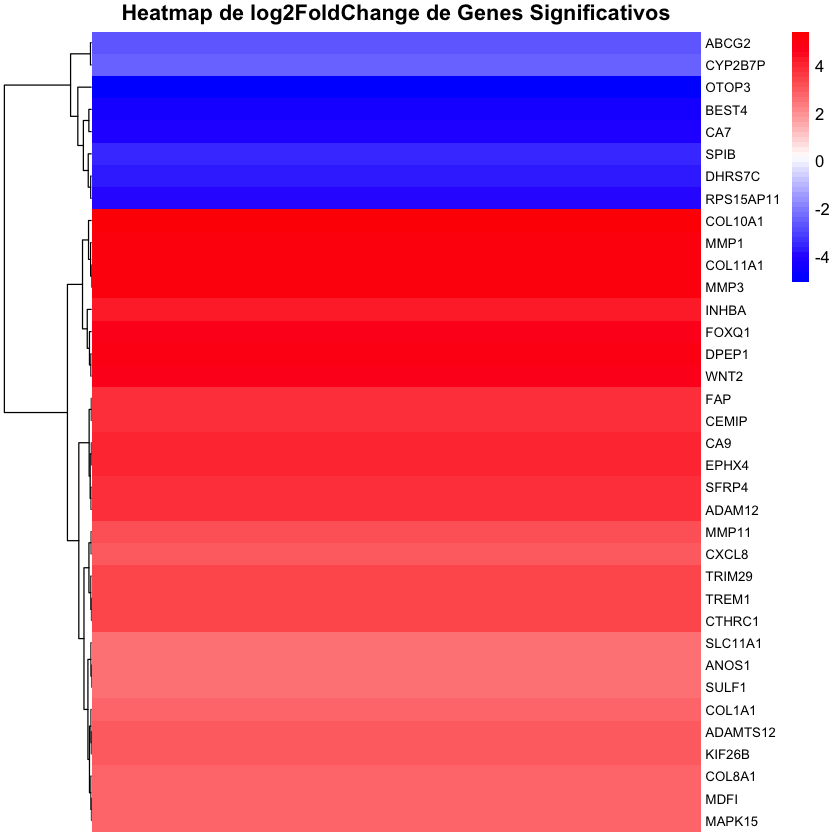

In [17]:
#########################################
# 9. Heatmap de genes significativos
#########################################
# Cargar la tabla filtrada de genes significativos y generar un heatmap (utilizando log2FoldChange)
significativos_table <- read.csv("/Users/usuario/Documents/programas/oncology_diff_express/significativo.csv")
gene_log2FC <- data.frame(Gene.Name = significativos_table$Gene.Name, log2FoldChange = significativos_table$log2FoldChange)
matriz_log2FC <- as.matrix(gene_log2FC$log2FoldChange)
rownames(matriz_log2FC) <- gene_log2FC$Gene.Name

pheatmap(matriz_log2FC,
         color = colorRampPalette(c("blue", "white", "red"))(50),
         border_color = NA,
         cluster_cols = FALSE,  # Sólo hay una columna
         cluster_rows = TRUE,   # Agrupar genes
         main = "Heatmap de log2FoldChange de Genes Significativos",
         fontsize_row = 8,
         show_colnames = FALSE)

# 10. Sección final: Enriquecimiento de genes y herramientas complementarias

# Para un análisis más profundo, se recomienda utilizar:

# 1. Enriquecimiento de genes: https://maayanlab.cloud/Enrichr/
# 2. Análisis de redes e interacciones: https://string-db.org/
# 3. Bases de datos adicionales: https://ngdc.cncb.ac.cn/databasecommons/database/id/3061
# 4. Visualización y análisis de redes: Cytoscape


# Conclusión:

## Este script utiliza DESeq2 para detectar genes diferencialmente expresados, aplica normalización (size factors) y escalado (transformación VST) para estabilizar la varianza, y realiza análisis de ordenación (PCA y PCoA) para explorar la estructura global de los datos.

## Finalmente, se visualizan los resultados con gráficos de volcán y heatmaps, facilitando la identificación de biomarcadores.

